Dataset:

* **Employee ID:** The unique ID allocated for each employee (example: fffe390032003000)
* **Date of Joining:** The date-time when the employee has joined the organization (example: 2008-12-30)
* **Gender:** The gender of the employee (Male/Female)
* **Company Type:** The type of company where the employee is working (Service/Product)
* **WFH Setup Available:** Is the work from home facility available for the employee (Yes/No)
* **Designation:** The designation of the employee of work in the organization.
In the range of [0.0, 5.0] bigger is higher designation.
* **Resource Allocation:** The amount of resource allocated to the employee to work, ie. number of working hours.
In the range of [1.0, 10.0] (higher means more resource)
* **Mental Fatigue Score:** The level of fatigue mentally the employee is facing.
In the range of [0.0, 10.0] where 0.0 means no fatigue and 10.0 means completely fatigue.
* **Burn Rate:** The value we need to predict for each employee telling the rate of Burn out while working.
In the range of [0.0, 1.0] where the higher the value is more is the burn out.

## 0. Loading Libraries

In [1]:
import pandas as pd
import numpy as np
import statistics

from sklearn.preprocessing import PolynomialFeatures

from pandas_profiling import ProfileReport

from statsmodels.stats.outliers_influence import variance_inflation_factor

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

#models
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor

#scalers
from sklearn.preprocessing import MinMaxScaler

#cross vaidation
from sklearn.model_selection import cross_val_score, cross_val_predict
from scipy.stats import t, norm

import pickle

In [2]:
#!pip install pandas-profiling

## 1. Data Exploration 

In [3]:
#Reading CSV file
data = pd.read_csv('train.csv')
data.head()
data_copy1 = data.copy()

In [4]:
#Checking types of the features 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22750 entries, 0 to 22749
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Employee ID           22750 non-null  object 
 1   Date of Joining       22750 non-null  object 
 2   Gender                22750 non-null  object 
 3   Company Type          22750 non-null  object 
 4   WFH Setup Available   22750 non-null  object 
 5   Designation           22750 non-null  float64
 6   Resource Allocation   21369 non-null  float64
 7   Mental Fatigue Score  20633 non-null  float64
 8   Burn Rate             21626 non-null  float64
dtypes: float64(4), object(5)
memory usage: 1.6+ MB


In [5]:
data.describe()

,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
count,22750.000000,21369.000000,20633.000000,21626.000000
mean,2.178725,4.481398,5.728188,0.452005
std,1.135145,2.047211,1.920839,0.198226
min,0.000000,1.000000,0.000000,0.000000
25%,1.000000,3.000000,4.600000,0.310000
50%,2.000000,4.000000,5.900000,0.450000
75%,3.000000,6.000000,7.100000,0.590000
max,5.000000,10.000000,10.000000,1.000000


## 1.1.  Data profiling

In [6]:
#need to run this cell every time when opening notebook
profile = ProfileReport(data, title='Pandas Profiling Report')
profile.to_widgets()

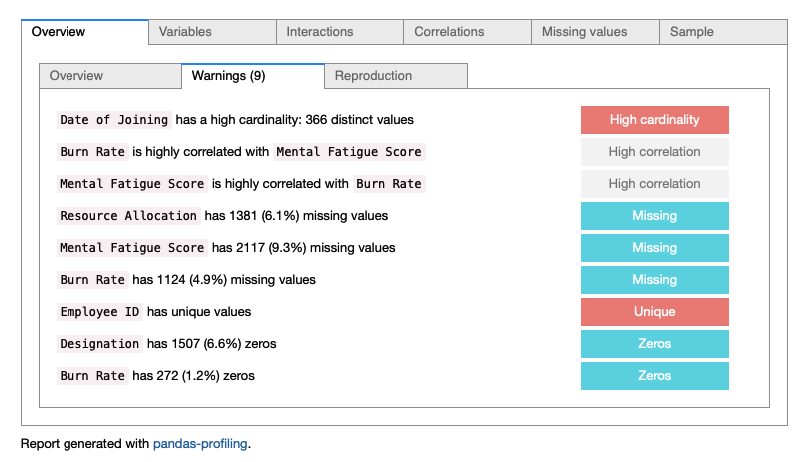

#### From profiling we see that the following issues need to be addressed:

1. Deal with NAN/zeros values (drop/leave/predict)
2. Date column - correct type
3. Check and deal with correlation

## 1.2. Categorical data

### 1.2.1. Date of Joining

With data visualisation in Tableau, we can see that date (month) of joining does not significantly affect Burn Rate as shown below: 

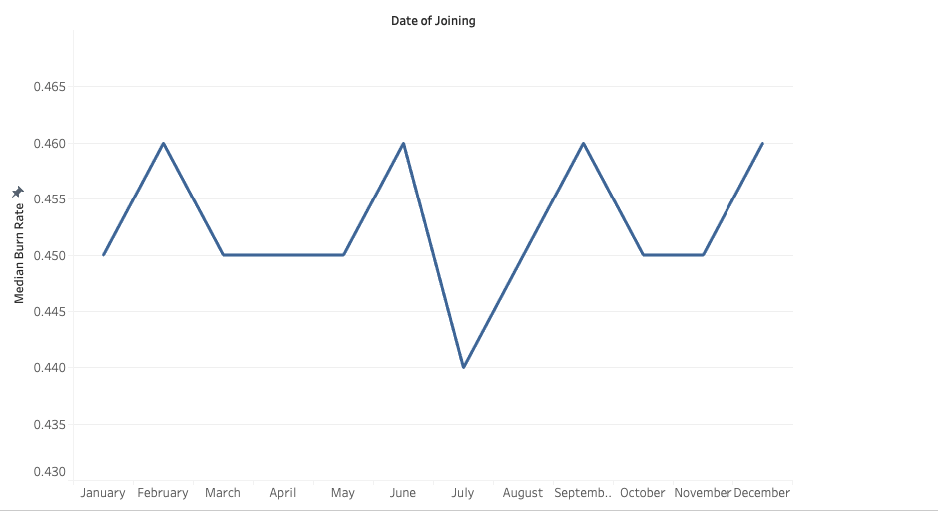

Dataset covers period of one year, so potentially if the period is longer and people have worked in a company for several years, joining date might affect the burn rate. 
(End of honey-moon phase) 

A this point we will drop the column. 

In [4]:
data = data.drop("Date of Joining", axis = 1)
data

,Employee ID,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
0,fffe32003000360033003200,Female,Service,No,2.0,3.0,3.8,0.16
1,fffe3700360033003500,Male,Service,Yes,1.0,2.0,5.0,0.36
2,fffe31003300320037003900,Female,Product,Yes,2.0,NaN,5.8,0.49
3,fffe32003400380032003900,Male,Service,Yes,1.0,1.0,2.6,0.20
4,fffe31003900340031003600,Female,Service,No,3.0,7.0,6.9,0.52
...,...,...,...,...,...,...,...,...
22745,fffe31003500370039003100,Female,Service,No,1.0,3.0,NaN,0.41
22746,fffe33003000350031003800,Female,Product,Yes,3.0,6.0,6.7,0.59
22747,fffe390032003000,Male,Service,Yes,3.0,7.0,NaN,0.72
22748,fffe33003300320036003900,Female,Service,No,2.0,5.0,5.9,0.52


### 1.2.1. Gender, Company Type, WFH setup

**OHE**  for the categorical data (excluding Emlployee ID):

In [5]:
data_d = data.drop('Employee ID', axis = 1)
data_d

,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
0,Female,Service,No,2.0,3.0,3.8,0.16
1,Male,Service,Yes,1.0,2.0,5.0,0.36
2,Female,Product,Yes,2.0,NaN,5.8,0.49
3,Male,Service,Yes,1.0,1.0,2.6,0.20
4,Female,Service,No,3.0,7.0,6.9,0.52
...,...,...,...,...,...,...,...
22745,Female,Service,No,1.0,3.0,NaN,0.41
22746,Female,Product,Yes,3.0,6.0,6.7,0.59
22747,Male,Service,Yes,3.0,7.0,NaN,0.72
22748,Female,Service,No,2.0,5.0,5.9,0.52


In [6]:
data_d = pd.get_dummies(data_d, drop_first = True)
data_d

,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate,Gender_Male,Company Type_Service,WFH Setup Available_Yes
0,2.0,3.0,3.8,0.16,0,1,0
1,1.0,2.0,5.0,0.36,1,1,1
2,2.0,NaN,5.8,0.49,0,0,1
3,1.0,1.0,2.6,0.20,1,1,1
4,3.0,7.0,6.9,0.52,0,1,0
...,...,...,...,...,...,...,...
22745,1.0,3.0,NaN,0.41,0,1,0
22746,3.0,6.0,6.7,0.59,0,0,1
22747,3.0,7.0,NaN,0.72,1,1,1
22748,2.0,5.0,5.9,0.52,0,1,0


In [7]:
#changing back order of columns
data_d = data_d[['Gender_Male', 'Company Type_Service',
       'WFH Setup Available_Yes', 'Designation', 'Resource Allocation',
       'Mental Fatigue Score', 'Burn Rate']]

In [11]:
data_d

,Gender_Male,Company Type_Service,WFH Setup Available_Yes,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
0,0,1,0,2.0,3.0,3.8,0.16
1,1,1,1,1.0,2.0,5.0,0.36
2,0,0,1,2.0,NaN,5.8,0.49
3,1,1,1,1.0,1.0,2.6,0.20
4,0,1,0,3.0,7.0,6.9,0.52
...,...,...,...,...,...,...,...
22745,0,1,0,1.0,3.0,NaN,0.41
22746,0,0,1,3.0,6.0,6.7,0.59
22747,1,1,1,3.0,7.0,NaN,0.72
22748,0,1,0,2.0,5.0,5.9,0.52


In [12]:
data_d['Designation'].unique()

array([2., 1., 3., 0., 4., 5.])

## 1.3. Numerical Data 

### 1.3.1. Dealing with NAN/zero values. 

In [13]:
#checking nul - values
nulls = pd.DataFrame(data.isna().sum()/len(data))
nulls= nulls.reset_index()
nulls.columns = ['column_name', 'Percentage Null Values']
nulls.sort_values(by='Percentage Null Values', ascending = False)

,column_name,Percentage Null Values
6,Mental Fatigue Score,0.093055
5,Resource Allocation,0.060703
7,Burn Rate,0.049407
0,Employee ID,0.000000
1,Gender,0.000000
2,Company Type,0.000000
3,WFH Setup Available,0.000000
4,Designation,0.000000


### 1.3.1.1.  Resource allocation 

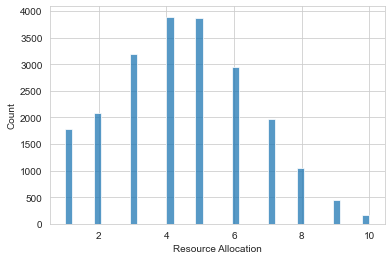

In [14]:
#checking distribution
sns.histplot(data['Resource Allocation'])

**Fill missing values** 
in this case it would make sense to fill it with mean value per designation (seniority within a company)

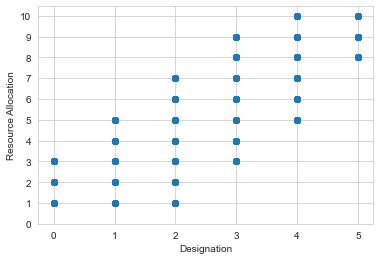

In [15]:
#distribution of resource allocation according to designation: 

plt.scatter("Designation", "Resource Allocation", data=data)
plt.xlabel("Designation")
plt.ylabel("Resource Allocation")
plt.yticks(range(0,11))
plt.show()

In [9]:
#find out mean per designation via group_by
designation_hours = data_d[['Designation','Resource Allocation']].groupby('Designation').mean().round(0)
designation_hours

,Resource Allocation
Designation,
0.0,1.0
1.0,3.0
2.0,4.0
3.0,6.0
4.0,7.0
5.0,9.0


In [10]:
#creating a dictionary to fill in na values from the df above
designation_dict = dict(zip(designation_hours.index, designation_hours['Resource Allocation']))
designation_dict

{0.0: 1.0, 1.0: 3.0, 2.0: 4.0, 3.0: 6.0, 4.0: 7.0, 5.0: 9.0}

In [11]:
#filling iin na values with the values drom fictionary
data_d['Resource Allocation'] = \
data_d['Resource Allocation'].fillna(data['Designation'].map(designation_dict))

In [12]:
#chrecking updated value counts
data_d['Resource Allocation'].value_counts(dropna = False)

4.0     4373
5.0     3861
3.0     3487
6.0     3298
7.0     2105
2.0     2075
1.0     1877
8.0     1044
9.0      471
10.0     159
Name: Resource Allocation, dtype: int64

### 1.3.1.2.  Burn Rate

This is our target, so in order to build a more accurate prediction we will drop missing values, since it's 6% of the data. 

In [13]:
data_copy2 = data_d.copy()

In [14]:
#filtering rows where "burn rate is not NAN"
data_d = data_d[data['Burn Rate'].notna()]

In [15]:
#checking nan values
data_d['Burn Rate'].isna().sum()

0

### 1.3.1.3.  Mental Fatigue Score

In [23]:
#calculating percentage of the nan values left:
data_d['Mental Fatigue Score'].isna().sum()/len(data_d)

0.08993803754739665

To make an appropriate decision on what to do with NAN values, we will first look at correlation between the features (see 1.3.2)

## 1.3.2. Correlation

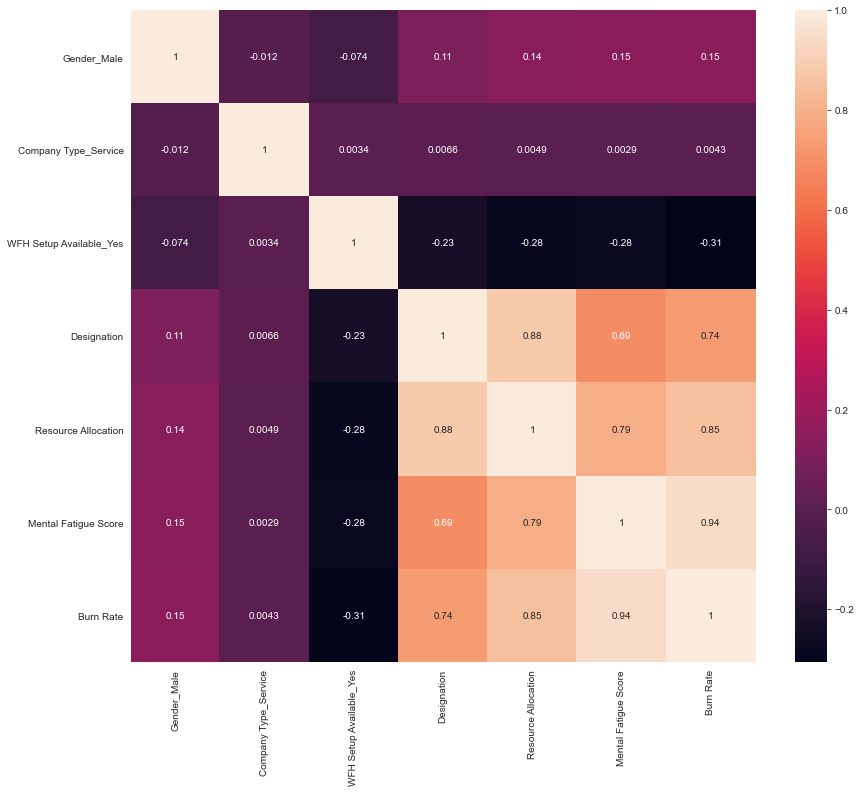

In [24]:
#correlation matric for all the data (including categorical - out of interest)
data_d.corr()
fig, ax = plt.subplots(figsize=(14, 12))
ax = sns.heatmap(data_d.corr(), annot=True)
plt.show()

**Correlation**
as we can see - target is highly correlated with 
- Mental Fatigue Score
- Designation
- Resourse Allocation

Mental Fatigue Score has the highest correlation, however it's also the only feature that takes input from the eployees themselves. 
In realy world it would not only depend on work, but other areas of life as well. 



**VIF** 

” VIF determines the strength of the correlation between the independent variables. It is predicted by taking a variable and regressing it against every other variable. “
or
VIF score of an independent variable represents how well the variable is explained by other independent variables.

R^2 value is determined to find out how well an independent variable is described by the other independent variables. A high value of R^2 means that the variable is highly correlated with the other variables. This is captured by the VIF which is denoted below:

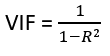

So, the closer the R^2 value to 1, the higher the value of VIF and the higher the multicollinearity with the particular independent variable.

In [25]:
#create a function to calculate VIF: 

def vif(X):
    ''' Calculatng VIF of the features - input - dataframe of features'''
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [26]:
#looking at features only:
X = data_d.dropna().drop(['Burn Rate'], axis = 1)
vif(X)

,variables,VIF
0,Gender_Male,1.912171
1,Company Type_Service,2.554093
2,WFH Setup Available_Yes,1.798943
3,Designation,21.267347
4,Resource Allocation,37.927079
5,Mental Fatigue Score,19.223757


It looks like we can bredict Mental fatigue score using other features, however at this point we will proceed with dropping NAN values in that column.

In [16]:
data_d = data_d[data['Mental Fatigue Score'].notna()]
data_d.shape

(19681, 7)

Now we don't have any NAN values left in the dataframe

In [28]:
#including target in VIF calculation
X = data_d
vif(X)

,variables,VIF
0,Gender_Male,1.912580
1,Company Type_Service,2.597056
2,WFH Setup Available_Yes,1.977925
3,Designation,21.289141
4,Resource Allocation,43.039664
5,Mental Fatigue Score,61.563100
6,Burn Rate,67.309147


We have some highly correllated features in the dataset, that might be problematic.
As this point we will proceed to modelling as is and will test whether dropping some of those features will help us improve the model in the future. 

## 2. Model

### 2.1. Raw data

In [17]:
X, y = data_d.drop(columns = ['Burn Rate'], axis = 1), data_d['Burn Rate']

In [19]:
def model_list(X, y, l, testsize = 0.2):
    '''Function to check different models:
    INPUT:
       x - dataframe features
       y - target
       l - list comtaing models we need to test 
       i.e. ['LIN', 'KNN', 'MPL', 'R_FOREST']  
    OUTPUT:
        MAE, MSE, R2, R2adj'''
   
    
    #creating a dataframe to display result of a function
    
    result = pd.DataFrame(columns = l, index = ['MAE', 'MSE','R2', 'R2_adj'])
    
    
    # train -test split, 20%
    X_train, X_test, y_train, y_test = train_test_split \
            (X, y, test_size = testsize, random_state=42)

    #looping throuhg the list of models:
    
    for i in range(len(l)):
        if l[i] == 'KNN':
            model = KNeighborsRegressor(n_neighbors = 5) 
            
        elif l[i] == 'LIN':     
            model = LinearRegression()
            
        elif l[i] == 'MPL':
            model = MLPRegressor(random_state=1, max_iter=2000) 
            
        elif l[i] == 'R_FOREST':
            model = RandomForestRegressor() 
            
        else:
            print('model {} can not be processed by function'.format(l[i]))
            
            
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test) #predictions
        
        #dataframe of the results: 
        result[l[i]][0] = mean_absolute_error(y_test,y_pred) #MAE
        result[l[i]][1] = mean_squared_error(y_test,y_pred) #MSE
        result[l[i]][2] = r2_score(y_test,y_pred) # R2
        result[l[i]][3] =  1 - (1-r2_score(y_test, y_pred))* \
        (len(y_test)-1)/(len(y_test)-X_test.shape[1]-1) #R2 adj
        
    return result 
    

In [18]:
X

,Gender_Male,Company Type_Service,WFH Setup Available_Yes,Designation,Resource Allocation,Mental Fatigue Score
0,0,1,0,2.0,3.0,3.8
1,1,1,1,1.0,2.0,5.0
2,0,0,1,2.0,4.0,5.8
3,1,1,1,1.0,1.0,2.6
4,0,1,0,3.0,7.0,6.9
...,...,...,...,...,...,...
22743,0,0,1,1.0,3.0,6.0
22744,1,0,0,3.0,7.0,6.2
22746,0,0,1,3.0,6.0,6.7
22748,0,1,0,2.0,5.0,5.9


In [20]:
l = ['LIN','R_FOREST', 'MPL']
test = model_list(X, y, l)
test

,LIN,R_FOREST,MPL
MAE,0.0454856,0.0455487,0.045996
MSE,0.00307091,0.00326549,0.00319734
R2,0.921487,0.916512,0.918254
R2_adj,0.921367,0.916385,0.91813


In [22]:
#saving Random forest model for tests
X_train, X_test, y_train, y_test = train_test_split \
            (X, y, test_size = 0.2, random_state=42)

model = RandomForestRegressor()
model.fit(X_train, y_train)

with open('rf_model.pkl', 'wb') as file: 
    pickle.dump(model, file)

This is the result as is, next steps to try tuning models.

**Linear** 
1. Try normalisation/Scaling of the data 
2. Try Polynomial features

**R_Forest** 
1. Hyperparameters tuning

### 2.2. Linear model 

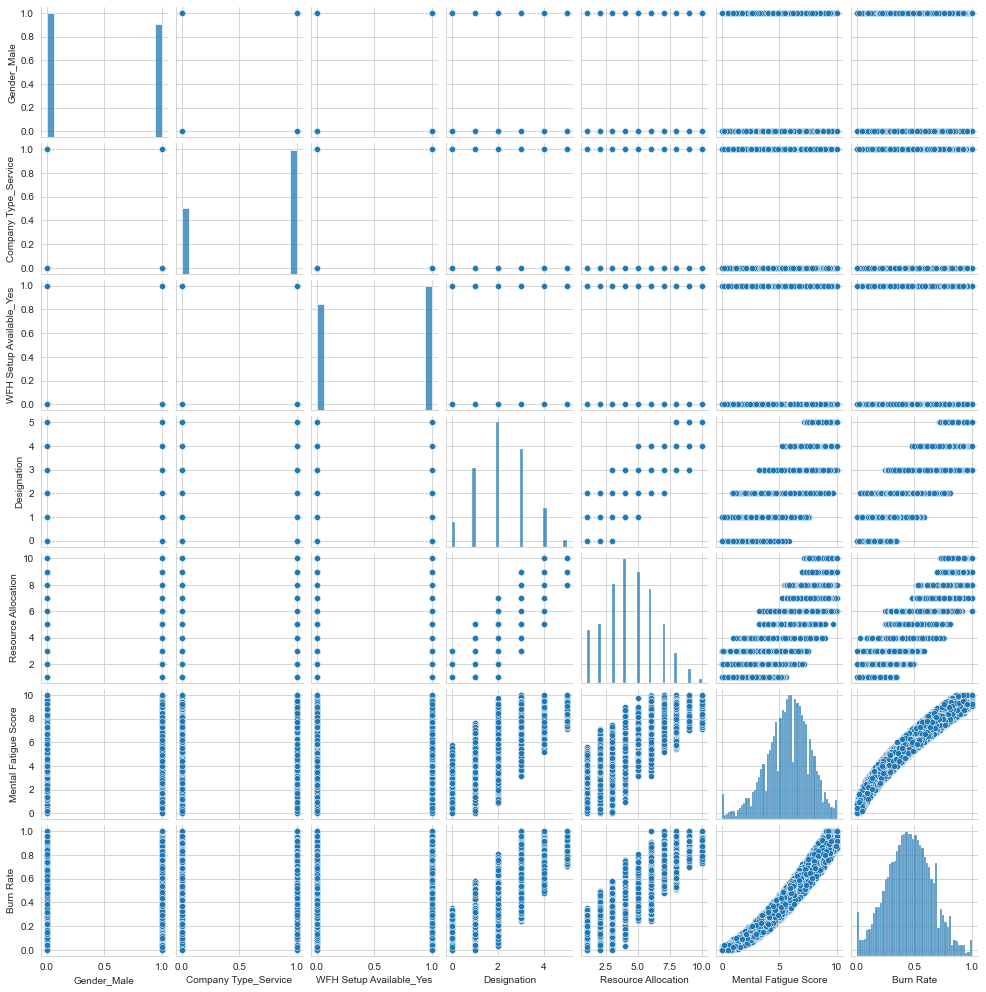

In [32]:
sns_plot = sns.pairplot(data_d, height=2)

### 2.2.1. Polynomial features

In [33]:
#degree was chosen after trials in range (2,6)
poly_reg_transform = PolynomialFeatures(degree=5)
X_poly = poly_reg_transform.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split \
            (X_poly, y, test_size = 0.2, random_state=42)

poly_reg_model = LinearRegression()
poly_reg_model.fit(X_train,y_train)
y_pred = poly_reg_model.predict(X_test)

MAE = mean_absolute_error(y_test,y_pred) #MAE
MSE = mean_squared_error(y_test,y_pred) #MSE
R2 = r2_score(y_test,y_pred) # R2
R2adj =  1 - (1-r2_score(y_test, y_pred))* \
        (len(y_test)-1)/(len(y_test)-X_test.shape[1]-1) #R2 adj

print('MAE=', MAE)
print('MSE=', MSE)
print('R2=', R2)
print('R2adj=', R2adj)

MAE= 0.04292177584450489
MSE= 0.002743087626745934
R2= 0.929868175193883
R2adj= 0.9205414903751075


In [34]:
with open('poly_model.pkl', 'wb') as file: 
    pickle.dump(poly_reg_model, file)

Using polynomial features improved R2 and reduced errors. 

### 2.2.2. Scaling

In [35]:
data_d.describe()

,Gender_Male,Company Type_Service,WFH Setup Available_Yes,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
count,19681.000000,19681.000000,19681.000000,19681.000000,19681.000000,19681.000000,19681.000000
mean,0.476195,0.654032,0.539454,2.176922,4.484173,5.729851,0.451981
std,0.499446,0.475695,0.498454,1.132797,2.027671,1.920784,0.197823
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,1.000000,3.000000,4.600000,0.320000
50%,0.000000,1.000000,1.000000,2.000000,4.000000,5.900000,0.450000
75%,1.000000,1.000000,1.000000,3.000000,6.000000,7.100000,0.590000
max,1.000000,1.000000,1.000000,5.000000,10.000000,10.000000,1.000000


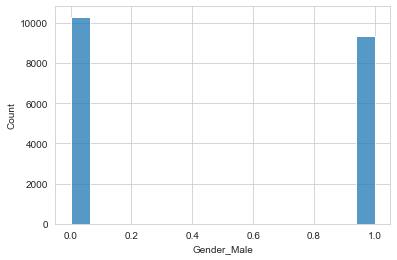

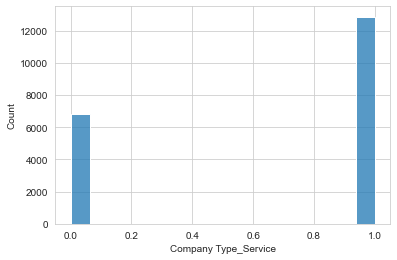

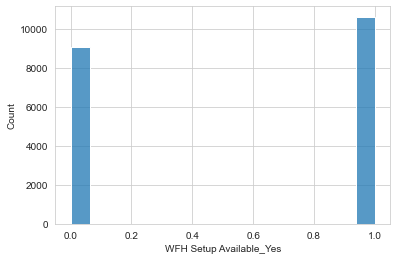

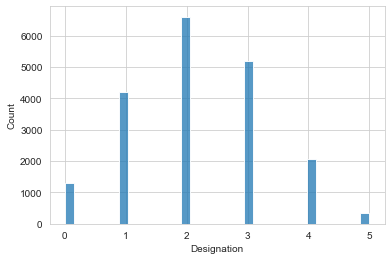

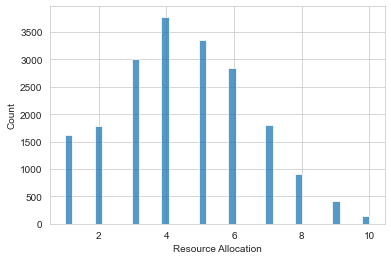

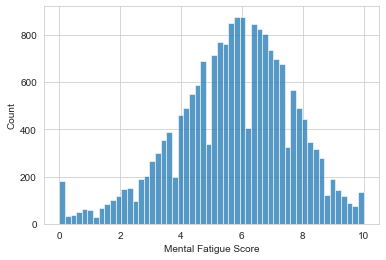

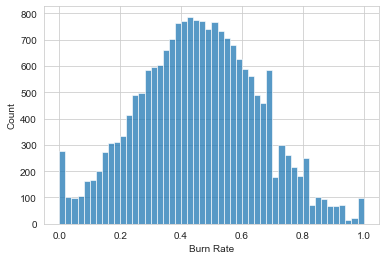

In [36]:
for column in data_d.columns:
    sns.histplot(data_d[column])
    plt.show()

In [37]:
X, y = data_d.drop(columns = ['Burn Rate'], axis = 1), data_d['Burn Rate']

In [38]:
X

,Gender_Male,Company Type_Service,WFH Setup Available_Yes,Designation,Resource Allocation,Mental Fatigue Score
0,0,1,0,2.0,3.0,3.8
1,1,1,1,1.0,2.0,5.0
2,0,0,1,2.0,4.0,5.8
3,1,1,1,1.0,1.0,2.6
4,0,1,0,3.0,7.0,6.9
...,...,...,...,...,...,...
22743,0,0,1,1.0,3.0,6.0
22744,1,0,0,3.0,7.0,6.2
22746,0,0,1,3.0,6.0,6.7
22748,0,1,0,2.0,5.0,5.9


In [39]:
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X))
X_scaled.columns = X.columns
X_scaled.describe()

,Gender_Male,Company Type_Service,WFH Setup Available_Yes,Designation,Resource Allocation,Mental Fatigue Score
count,19681.000000,19681.000000,19681.000000,19681.000000,19681.000000,19681.000000
mean,0.476195,0.654032,0.539454,0.435384,0.387130,0.572985
std,0.499446,0.475695,0.498454,0.226559,0.225297,0.192078
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.200000,0.222222,0.460000
50%,0.000000,1.000000,1.000000,0.400000,0.333333,0.590000
75%,1.000000,1.000000,1.000000,0.600000,0.555556,0.710000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [40]:
l = ['LIN','R_FOREST', 'MPL']
test = model_list(X_scaled, y, l)
test

,LIN,R_FOREST,MPL
MAE,0.0454856,0.0455515,0.0443441
MSE,0.00307091,0.00327283,0.00291556
R2,0.921487,0.916324,0.925459
R2_adj,0.921367,0.916197,0.925345


Scaling did not really affect the models

In [41]:
poly_reg_transform = PolynomialFeatures(degree=5)
X_poly = poly_reg_transform.fit_transform(X_scaled)

X_train, X_test, y_train, y_test = train_test_split \
            (X_poly, y, test_size = 0.2, random_state=42)

poly_reg_model = LinearRegression()
poly_reg_model.fit(X_train,y_train)
y_pred = poly_reg_model.predict(X_test)

MAE = mean_absolute_error(y_test,y_pred) #MAE
MSE = mean_squared_error(y_test,y_pred) #MSE
R2 = r2_score(y_test,y_pred) # R2
R2adj =  1 - (1-r2_score(y_test, y_pred))* \
        (len(y_test)-1)/(len(y_test)-X_test.shape[1]-1) #R2 adj

print('MAE=', MAE)
print('MSE=', MSE)
print('R2=', R2)
print('R2adj=', R2adj)

MAE= 0.043022660771600094
MSE= 0.0027484827671885852
R2= 0.9297302390081632
R2adj= 0.9203852103443093


In [42]:
error = pd.DataFrame()
error['test'] = y_test
error['pred'] = y_pred
error['AE'] = abs(y_test - y_pred)
error['E'] = (y_test - y_pred)
error.describe()

,test,pred,AE,E
count,3937.000000,3937.000000,3937.000000,3937.000000
mean,0.445184,0.442824,0.043023,0.002360
std,0.197796,0.191113,0.029963,0.052379
min,0.000000,-0.015238,0.000008,-0.146472
25%,0.300000,0.313856,0.018453,-0.036126
50%,0.440000,0.439011,0.038318,0.003184
75%,0.580000,0.581373,0.062544,0.040472
max,1.000000,0.960287,0.168093,0.168093


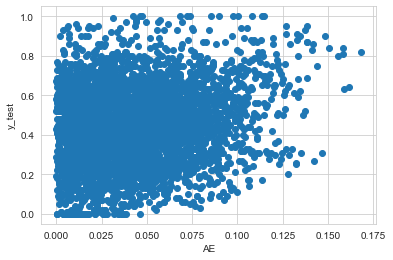

In [43]:
plt.scatter('AE', 'test', data=error)
plt.xlabel("AE")
plt.ylabel("y_test")
#plt.yticks(range(0,11))
plt.show()

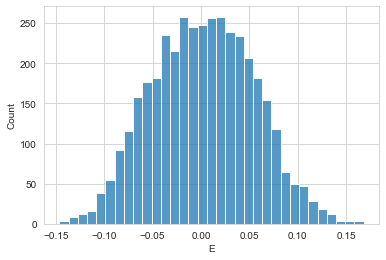

In [44]:
#error distribution
sns.histplot(error['E'])

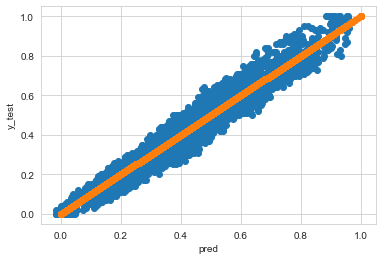

In [45]:
plt.scatter('pred', 'test', data=error)
plt.scatter('test', 'test', data=error)
plt.xlabel("pred")
plt.ylabel("y_test")
#plt.yticks(range(0,11))
plt.show()

In [46]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, cross_val_predict
from scipy.stats import t, norm

In [47]:

model2 = LinearRegression()
model3 = RandomForestRegressor()
model_pipeline = [model2]#, model3
model_names = ['Linear Regression']



def func(model_pipeline, model_names, X_train, y_train, alpha = 0.05, K = 10):
    
# We set the significance level
#alpha = 0.05
#K = 10
    scores = {}
    i=0
    for model in model_pipeline:
        mean_score = np.mean(cross_val_score(model, X_train, y_train, cv= K))
        if (K < 30):
            t_critical = abs(t.ppf(alpha, K-1))
            interval = t_critical*(np.std(cross_val_score(model, X_train, y_train, cv=K))/np.sqrt(K))
        else:
            z_critical = abs(norm.ppf(1-alpha/2))
            interval = z_critical*(np.std(cross_val_score(model, X_train, y_train, cv=K))/np.sqrt(K))
        scores[model_names[i]] = [mean_score, mean_score - interval, mean_score + interval]
        print("The rmse of the {} model is (CV witk K={}) {:4.2f} +/- {:4.2f}".format(model_names[i], K, mean_score, interval))
        i = i+1
    #print(scores)

In [48]:
func(model_pipeline, model_names, X_train, y_train, alpha = 0.01, K = 5)

The rmse of the Linear Regression model is (CV witk K=5) 0.93 +/- 0.00


### 2.3. Random Forest 

In [49]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100], # 50 OR 100, otherwise: list(range(50,101))
    'min_samples_split': [2, 4], 
    'min_samples_leaf' : [1, 2], #small vakues - potentially overfitted - uses every posssible sample when 1
    'max_features': ['sqrt']
    }

clf = RandomForestRegressor(random_state=100)

grid_search = GridSearchCV(clf, param_grid, cv=4,return_train_score=True,n_jobs=-1, verbose = 20)
grid_search.fit(X_train,y_train)
grid_search.best_params_ #To check the best set of parameters returned

Fitting 4 folds for each of 8 candidates, totalling 32 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   41.3s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   41.4s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   41.4s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   41.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   49.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   49.9s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:   49.9s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:   50.1s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:  1

KeyboardInterrupt: 

In [ ]:
from sklearn.model_selection import cross_val_score

clf = RandomForestRegressor(random_state=100, max_features='sqrt', min_samples_leaf=2, min_samples_split=2, n_estimators=100)
cross_val_scores = cross_val_score(clf, X_train, y_train, cv=5)
print(np.mean(cross_val_scores))